<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="height:80px; display: inline"  alt="INSA"/></a> 

# Tutoriel en R: Détecter, Mesurer, Expliquer, Atténuer, la Discrimination Indirecte des Algorithmes d'Apprentissage Statistique

**Résumé**
Analyse de données extraites d'un recensement aux USA de 1994 et disponibles sur le [dépôt de l'UCI](http://archive.ics.uci.edu/ml/). Elles permettent de mettre en relation le niveau de revenu (inférieur ou supérieur à 50k$), analogue à une "solvabilité" ou score de crédit, avec d'autres variables dont certaines sensibles car indiquant l'appartenance à un groupe protégé par la loi: sexe, origine ethnique. Différents indicateurs de biais donc de sources de discrimination indirecte vis à vis d'un groupe, sont définis et illustrés sur ces données. Les principaux, consensuels dans la littérature, sont l'effet disproportionné ou *disparate / adverse impact* (DI) (*demographic equality*), le taux d'erreur conditionnel (*overall error equality*) et des mesures associées à l'asymétrie des matrices de confusion conditionnellement au groupe (*equalized odds*). Le tutoriel conduit a estimer ces différents biais lors de la prévision de la solvabilité par régression logistique (linéaire) en comparaison avec un algorithme de forêts aléatoires (non linéaire). La doctrine "officielle" des enquêtes par *testing*, adaptée pour détecter une discrimination individuelle directe, est également évaluée sur les prévisions de ces deux algorithmes. Une procédure élémentaire d'atténuation du biais systémique par *post-processing* est enfin exécutée afin d'évaluer son impact sur la précision de prévision et les autres biais.  

**Remarque**
- Les principaux résultats de ce tutoriel ont servi d'illustration pour une intervention lors d'un séminaire commun CNIL & Défenseur des Droits (05/2020); ils sont détaillés dans un article soumis ([Besse, 2020)](https://hal.archives-ouvertes.fr/hal-02616963)).
- Ce tutoriel peut être exécuté en local après chargement ou clônage du dépôt ou encore dans le nuage *Google Colab* en cliquant sur le lien ci-dessous:

<a href="https://colab.research.google.com/github/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Introduction
### 1.1 Les données
Des données publiques disponibles sur le site [UCI repository](http://archive.ics.uci.edu/ml/) sont extraites de la base de données issue du recensement réalisé aux Etats Unis en 1994. Les deux fichiers *train* et *test* on été réunis en un seul. Ces données son largement utilisées et font référence comme outil de *benchmark* pour comparer les performances de méthodes d’apprentissage. L’objectif est de prévoir, avec plus ou moins de biais, la variable binaire "revenu annuel" supérieur ou inférieur à 50k$. Cette prévision n'impacte pas la personne mais comme la démarche et le contexte sont tout à fait similaires à ce que pourrait faire une banque pour évaluer un risque de crédit, cet exemple est très illustratif. Ce jeu de données est systématiquement utilisé (bac à sable) pour évaluer les propriétés des algorithmes d'apprentissage équitable ou loyal (*fair learning*) car, contrairement à beaucoup d'autres jeux de données utilisés pour cette fin (*e.g. german credit bank*), la vraie valeur de la variable cible est connue ainsi que l'origine ethnique des personnes concernées.

Dans les données initiales, 48.842 individus sont décrits par les 14 variables du tableau ci-dessous:


|Num|Libellé|Ensemble de valeurs|
|-|---------:|-------------------:|
|1|`Age`|real|
|2|`workClass`|Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked|
|3|`fnlwgt`|real|
|4|`education`|Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool|
|5|`educNum`|integer|
|6|`mariStat`|Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse|
|7|`occup`|Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces|
|8|`relationship`|Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
|9|`origEthn`|White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black|
|10|`sex`|Female, Male|
|11|`capitalGain`|real| 
|12|`capitalLoss`|real|
|13|`hoursWeek`|real|
|14|`nativCountry`|United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands|
|15|`income`|>50K, <=50K|


### 1.2 Préparation des données

Le traitement commence par une préparation détaillée des données:
- lecture et prise en charge des données en remarquant que la variable `fnlwgt` (Final sampling weight) a un [statut particulier](http://web.cs.wpi.edu/~cs4341/C00/Projects/fnlwgt) pas très clair; elle est éliminée;
- suppression des observations présentant des données manquantes, erreurs ou incohérences,
- regroupement des modalités très dispersées, 
- suppression des variables redondantes. 

### 1.3 Estimation des biais

Parmi tous les critères de biais existant susceptibles de mettre en évidence une discrimination indirecte (Zliobaitė, 2015), trois ont été privilégiés (cf. Vermat et Rubin, 2018): 
1. discrimination indirecte par l'effet disproportionné: *disparate impact* ou *demographic equality*
2. comparaison des taux d'erreur conditionnels: *overall error equality*
3. comparaison des rapports de cote: *conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds*.

L'accent est mis dans ce premier tutoriel sur l'estimation de l'effet disproportionné (*disparate* ou *adverse impact*) vis-à-vis du sexe. L'approximation de l'intervalle de confiance (Besse et al. 2018) est comparée avec une estimation *bootstrap* conduisant aux mêmes résultats. Les estimations sont calculées sur les données initiales de la base (biais de société ou systémique) puis sur les prévisions du seuil de revenu obtenues par deux algorithmes (régression logistique et forêts aléatoires) pour évaluer le risque de discrimination. 

**Remarques** 
- un [calepin plus détaillé](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb) mais plus long propose une analyse exploratoire détaillée (AFCM) et une comparaison des impacts des autres algorithmes d'apprentissage et donc de leur effet discriminatoire fonction du biais de société (sexe et origine ethnique). Cela permet d'en mieux comprendre les origines selon le déséquilibre des classes et surtout selon l'importance des interactions entre les variables. 
- le site [aif360](https://aif360.mybluemix.net/) propose également un ensemble d'exemples et tutoriels. Il est plus riche: autres jeux de données, autres critères et surtout plus d'algorithmes de débiaisage, mais présente soit des démonstrations triviales, soit des exemples de méthodes très sophistiquées d'atténuation du biais. Ce tutoriel se veut plus pédagogique pour appréhender pas-à-pas les problèmes. 

## 2 Exploration des données
Lors de cette phase de travail, il y a deux points de vue radicalement différents. 
- Celui illustré par Friedler et al. (2019) consiste à entraîner un algorithme sur les données brutes sans exploration "humaine" préalable faisant appel à des compétences statistiques; par principe, tout est automatisé.
- Celui proposé dans ce tutoriel est le résultat d'une démarche nécessitant des compétences élémentaires  statistiques pour explorer les données, comprendre leur structure, détecter les problèmes potentiels: données manquantes, atypiques, biais, classes rares, distributions "anormales"...) afin d'y remédier au mieux, et d'illustrer l'intérêt de l'objectif poursuivi.

Remarquons que ce deuxième point de vue de connaissance des données semble plus respectueux des [lignes directrices des experts de la CE pour une IA igne de confiance](https://ec.europa.eu/futurium/en/ai-alliance-consultation) et anticipe donc un futur réglement européen annoncé par le [livre blanc](https://ec.europa.eu/info/sites/info/files/commission-white-paper-artificial-intelligence-feb2020_fr.pdf).
### 2.1 Lecture et premières transformations
Deux possibilités pour charger les données issues du dépôt de l'UCI en fonction du mode d'exécution adopté; en local après avoir installé R ou à distance dans le nuage *Google Colab*. 
1. Dans le premier cas, les données sont chargées en même temps que le dépôt *Github*,
2. Dans le deuxième cas, <a href="https://colab.research.google.com/github/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
les données et le programme de transformation sont chargés et lus dans l'environnement de *Google Colab*; il est nécessaire d'exécuter la cellule ci-dessous.

In [ ]:
# Exécuter cette cellule lors d'une exécution dans le nuage Google Colab
# sinon les données et fonctions sont déjà chargées en local
system("wget -P . https://github.com/wikistat/Fair-ML-4-Ethical-AI/raw/master/AdultCensus/adultTrainTest.csv")
system("wget -P . https://github.com/wikistat/Fair-ML-4-Ethical-AI/raw/master/AdultCensus/dataPrepAdultCensus.R")
system("wget -P . https://github.com/wikistat/Fair-ML-4-Ethical-AI/raw/master/AdultCensus/diVSalgos-red.txt")
system("mkdir ../Functions")
system("wget -P ../Functions https://raw.githubusercontent.com/wikistat/Fair-ML-4-Ethical-AI/master/Functions/dispImp.R")
system("wget -P ../Functions https://raw.githubusercontent.com/wikistat/Fair-ML-4-Ethical-AI/master/Functions/overErrEqual.R")
system("wget -P ../Functions https://raw.githubusercontent.com/wikistat/Fair-ML-4-Ethical-AI/master/Functions/oddsEqual.R")

In [25]:
source("dataPrepAdultCensus.R")
dataBase = dataPrepAdultCensus()
summary(dataBase)

      age                workClass         fnlwgt              education    
 Min.   :18.00   Federal-Govt : 1390   Min.   :  13492   HS-grad    :14766  
 1st Qu.:28.00   Not-Working  :   21   1st Qu.: 117405   HS-Graduate: 9892  
 Median :37.00   Other-Govt   : 5023   Median : 178390   Bachelors  : 7569  
 Mean   :38.79   Private      :32856   Mean   : 189859   Dropout    : 5182  
 3rd Qu.:47.00   Self-Employed: 5425   3rd Qu.: 237999   Associates : 3466  
 Max.   :90.00                         Max.   :1490400   Masters    : 2512  
                                                         (Other)    : 1328  
    educNum               mariStat              occup      
 Min.   : 1.00   Married      :21079   Admin       : 5501  
 1st Qu.: 9.00   Never-Married:14100   Blue-Collar :14732  
 Median :10.00   Not-Married  : 8259   Other-occups: 2391  
 Mean   :10.16   Widowed      : 1277   Professional: 5992  
 3rd Qu.:13.00                         Sales       : 5272  
 Max.   :16.00          

### 2.2 Description statistique élémentaire
Mettre en évidence des difficultés présentes sur certaines variables ou couples de variables.

In [27]:
options(repr.plot.width=4, repr.plot.height=4)
hist(dataBase[,"capitalGain"],probability=T, main="",xlab="CapitalGain")
boxplot(dataBase[,"capitalGain"], horizontal=TRUE,boxwex=.2,  outline=TRUE,  
        frame=F, col = "lightgrey", add = TRUE,at=0.2)

ERROR: Error in hist.default(dataBase[, "capitalGain"], probability = T, main = "", : 'x' must be numeric


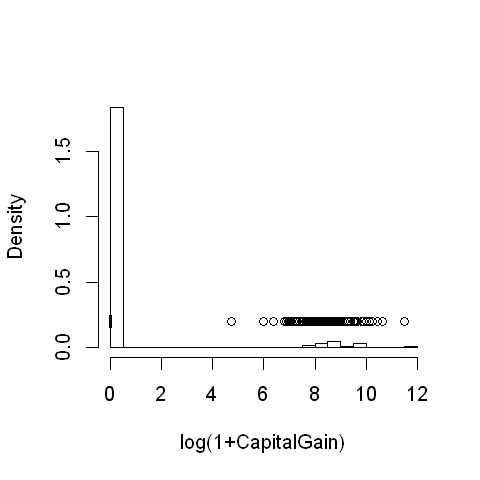

In [28]:
options(repr.plot.width=4, repr.plot.height=4)
hist(dataBase[,"LcapitalGain"],probability=T, main="",xlab="log(1+CapitalGain)")
boxplot(dataBase[,"LcapitalGain"], horizontal=TRUE,boxwex=.2,  outline=TRUE,  
        frame=F, col = "lightgrey", add = TRUE,at=0.2)

Nécessité de transformer certaines variables avant de contruire des modèles linéaires puis mise en évidence d'incohérences et de fortes redondances entre certaines variables.

In [29]:
table(dataBase$relationship,dataBase$sex)   

                
                 Female  Male
  Husband             1 18659
  Not-in-family    5404  6274
  Other-relative    599   721
  Own-child        2707  3477
  Unmarried        3649  1133
  Wife             2090     1

**Remarque:**: Deux données presentent des "Epoux" comme femme et "Epouse" comme Homme
En ignorant cette incohérence, il y a une redondance entre Husband et Male, puis Wife et Female

In [30]:
table(dataBase$education,dataBase$educNum)  

             
                  1     2     3     4     5     6     7     8     9    10    11
  Associates      0     0     0     0     0     0     0     0     0     0  1959
  Bachelors       0     0     0     0     0     0     0     0     0     0     0
  Doctorate       0     0     0     0     0     0     0     0     0     0     0
  Dropout        72   222   446   819   644  1073  1387   519     0     0     0
  HS-grad         0     0     0     0     0     0     0     0 14766     0     0
  HS-Graduate     0     0     0     0     0     0     0     0     0  9892     0
  Masters         0     0     0     0     0     0     0     0     0     0     0
  Prof-School     0     0     0     0     0     0     0     0     0     0     0
             
                 12    13    14    15    16
  Associates   1507     0     0     0     0
  Bachelors       0  7569     0     0     0
  Doctorate       0     0     0     0   544
  Dropout         0     0     0     0     0
  HS-grad         0     0     0 

In [31]:
table(dataBase$mariStat,dataBase$relationship)

               
                Husband Not-in-family Other-relative Own-child Unmarried  Wife
  Married         18660            19            184       125         0  2091
  Never-Married       0          6667            793      5423      1217     0
  Not-Married         0          4305            284       616      3054     0
  Widowed             0           687             59        20       511     0

In [32]:
table(dataBase$origEthn,dataBase$nativCountry)

             
              British-Commonwealth China Euro_1 Euro_2 Latin-America Other
  Amer-Indian                    0     1      1      2            12     0
  Asian                        125   185      4    101            13    61
  Black                         11     0     10      0           230     8
  Other                         12     0      2      1           125    11
  White                        333    10    313    229          1157   198
             
              SE-Asia South-America United-States
  Amer-Indian       1             1           410
  Asian           416             0           397
  Black             4             2          3929
  Other             0            31           166
  White            20           278         35905

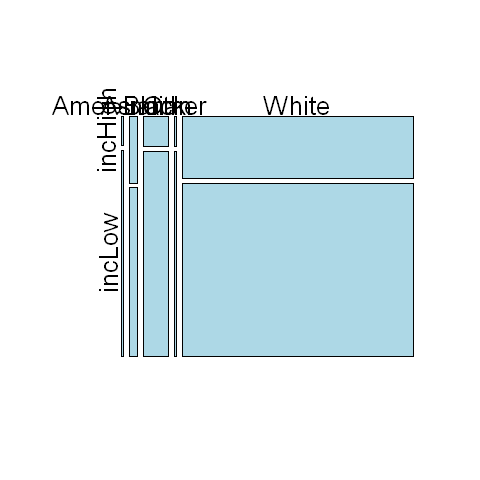

In [33]:
mosaicplot(table(dataBase[,"origEthn"],dataBase[,"income"]),main="", col="lightblue",cex=1.3)

Quelques modifications sont apportées dans la base; des variables sont supprimées afin de ne garder qu'une seule présence d'une information sensible: sexe et origine ethnique.
- Suppression de la variable 3 `fnlwgt` qui n'a guère de signification pour cette analyse.
- Création d'une variable binaire `Child`: présence ou non d'enfants.
- Suppression de la variable 8 `relationship` redondante avec le sexe et le statut marital,
- Suppression de la variable 14 `nativCountry` redondante avec l'origine ethnique.
- La variable 9 `originEthn` est simplifiée à 2 classes: CaucYes *vs.* CaucNo

**Attention** Pour la suite, il est important que les niveaux des facteurs soient ordonnés de façon cohérente pour la bonne interprétation des tables de contingence et de leurs effectifs. Par convention, les modalités pré-jugées socialement "dévavorables": revenu faible, femme, non caucasien (codées 0), précèdent les autres: revenu élevé, homme, caucasien (codées 1). Il faut donc soit réordonner les niveaux de la variable `income` ou renommer les modalités pour faire correspondre l'ordre alphabétique; ce deuxième choix est exécuté.

In [34]:
dataBase[,"child"]=as.factor(ifelse(dataBase$relationship=='Own-child',"ChildYes","ChildNo"))
dataBase[,"origEthn"]=as.factor(ifelse(dataBase$origEthn %in% c('Amer-Indian','Asian','Black','Other'),"CaucNo","CaucYes"))
dataBase[,"income"]=as.factor(ifelse(dataBase$income=='incLow',"incB","incH"))
datBas=dataBase[,-c(3,8,14)]
summary(datBas)

      age                workClass           education        educNum     
 Min.   :18.00   Federal-Govt : 1390   HS-grad    :14766   Min.   : 1.00  
 1st Qu.:28.00   Not-Working  :   21   HS-Graduate: 9892   1st Qu.: 9.00  
 Median :37.00   Other-Govt   : 5023   Bachelors  : 7569   Median :10.00  
 Mean   :38.79   Private      :32856   Dropout    : 5182   Mean   :10.16  
 3rd Qu.:47.00   Self-Employed: 5425   Associates : 3466   3rd Qu.:13.00  
 Max.   :90.00                         Masters    : 2512   Max.   :16.00  
                                       (Other)    : 1328                  
          mariStat              occup          origEthn         sex       
 Married      :21079   Admin       : 5501   CaucNo : 6272   Female:14450  
 Never-Married:14100   Blue-Collar :14732   CaucYes:38443   Male  :30265  
 Not-Married  : 8259   Other-occups: 2391                                 
 Widowed      : 1277   Professional: 5992                                 
                       Sa

Quelques *mosaicplots* basiques montrent le lien des variables sensibles avec la cible (seuil de revenu) et mettent clairement en évidence le biais de société.

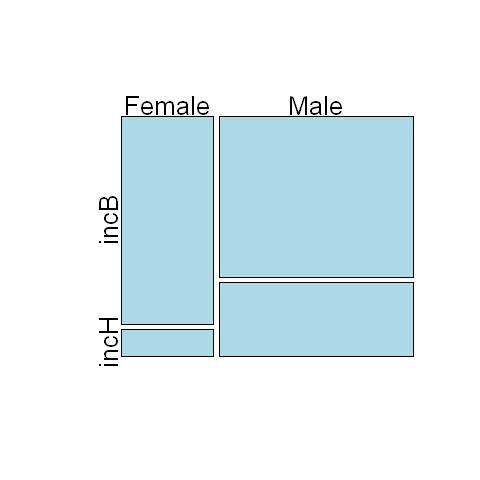

In [35]:
mosaicplot(table(datBas[,"sex"],datBas[,"income"]),main="", col="lightblue",cex=1.3)

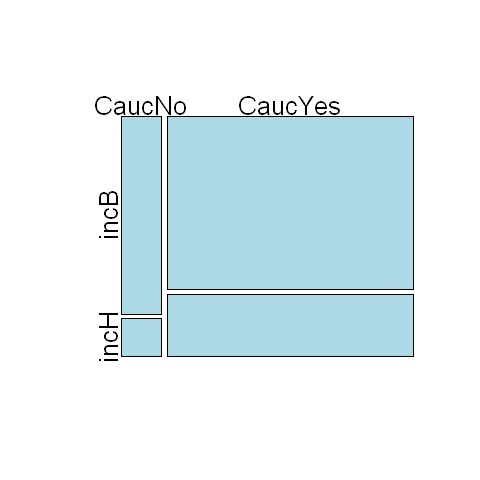

In [36]:
mosaicplot(table(datBas[,"origEthn"],datBas[,"income"]),main="",col="lightblue",cex=1.3)

**Q** Commentaires sur les biais présents dans la base, les déséquilibres des classes.

**On distingue deux biais du au desequilibre Male Female et le déséquilibre CaucNo et CaucYes.**
**D'après ces mosaiques, l'lgorithme ura tendance à predire un revenu faible pour les femmes (Female) et les non-caucasien (CaucNo). Cela va donc induire à une conclusion de non solvabilité pour les classes de Female et CaucNo.**
**Au regard de la largeur des rectangle, les hommes sont sur-représentés dans notre jeux de données. Et les caucasiens sont sur-représentés par rapport à au non caucasiens**


Le [calepin plus complet](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb) propose l'exécution d'une [analyse factorielle multiple des correspondances](http://wikistat.fr/pdf/st-m-explo-afcm.pdf) afin de représenter globalement la structure des liaisons entre les variables; c'est la raison pour laquelle les variables quantitatives ont été découpées en classes. Comme l'AFCM n'est pas reprise ici par souci de concision, ces variables sont abandonnées par la suite.

### 2.3 Préparation des échantillons
La base de données est divisée en deux échantillons d'apprentissage et de test. 

In [37]:
summary(datBas)

      age                workClass           education        educNum     
 Min.   :18.00   Federal-Govt : 1390   HS-grad    :14766   Min.   : 1.00  
 1st Qu.:28.00   Not-Working  :   21   HS-Graduate: 9892   1st Qu.: 9.00  
 Median :37.00   Other-Govt   : 5023   Bachelors  : 7569   Median :10.00  
 Mean   :38.79   Private      :32856   Dropout    : 5182   Mean   :10.16  
 3rd Qu.:47.00   Self-Employed: 5425   Associates : 3466   3rd Qu.:13.00  
 Max.   :90.00                         Masters    : 2512   Max.   :16.00  
                                       (Other)    : 1328                  
          mariStat              occup          origEthn         sex       
 Married      :21079   Admin       : 5501   CaucNo : 6272   Female:14450  
 Never-Married:14100   Blue-Collar :14732   CaucYes:38443   Male  :30265  
 Not-Married  : 8259   Other-occups: 2391                                 
 Widowed      : 1277   Professional: 5992                                 
                       Sa

Sélection des variables

In [38]:
datBas=datBas[,c("age","educNum","mariStat","occup","origEthn",
                 "sex","hoursWeek","income","LcapitalGain","LcapitalLoss","child")]
summary(datBas)
write.csv(datBas,file="adultBase-R.csv",row.names = FALSE)

      age           educNum               mariStat              occup      
 Min.   :18.00   Min.   : 1.00   Married      :21079   Admin       : 5501  
 1st Qu.:28.00   1st Qu.: 9.00   Never-Married:14100   Blue-Collar :14732  
 Median :37.00   Median :10.00   Not-Married  : 8259   Other-occups: 2391  
 Mean   :38.79   Mean   :10.16   Widowed      : 1277   Professional: 5992  
 3rd Qu.:47.00   3rd Qu.:13.00                         Sales       : 5272  
 Max.   :90.00   Max.   :16.00                         Service     : 4846  
                                                       White-Collar: 5981  
    origEthn         sex          hoursWeek      income       LcapitalGain   
 CaucNo : 6272   Female:14450   Min.   : 1.00   incB:33511   Min.   : 0.000  
 CaucYes:38443   Male  :30265   1st Qu.:40.00   incH:11204   1st Qu.: 0.000  
                                Median :40.00                Median : 0.000  
                                Mean   :41.17                Mean   : 0.747  
  

Extraction des échantillons d'apprentissage et de test. Vous pouvez changer la valeur initiale `seed` du générateur de nombre aléatoires afin d'obtenir une autre répartition entre apprentissage et test.

In [39]:
set.seed(11) # initialisation du générateur
# Extraction des échantillons
test.ratio=.2   # part de l'échantillon test
npop=nrow(datBas) # nombre de lignes dans les données
nvar=ncol(datBas) # nombre de colonnes
# taille de l'échantillon test
ntest=ceiling(npop*test.ratio) 
# indices de l'échantillon test
testi=sample(1:npop,ntest)
# indices de l'échantillon d'apprentissage
appri=setdiff(1:npop,testi) 

In [40]:
# construction de l'échantillon d'apprentissage
datApp=datBas[appri,]
# construction de l'échantillon test 
daTest=datBas[testi,]
# sauvegarde des fichiers pour le deuxième tutoriel
write.csv(datApp,"datApp.csv")
write.csv(daTest,"daTest.csv")

Définition d'une fonction pour calculer le taux d'erreur usuel de la matrice de confusion. Avec l'ordonnancement des modalités, les bien classés sont les termes diagonaux de la matrice de confusion.

In [41]:
tauxErr=function(table){round((table[1,2]+table[2,1])/sum(table)*100,2)}

## 3 Prévision du seuil de revenu 
Une comparaison détaillée (cf. le [tutoriel](https://github.com/wikistat/Apprentissage/blob/master/Adult-Census/Apprent-Python-AdultCensus.ipynb)) de la plupart des modèles et algorithmes de prévision du seuil de revenu en fonction des différentes variables met en évidence des résultats de prévision un peu meilleurs obtenus par l'algorithme de *gradient boosting* (version xtrem). Néanmoins, on peut se limiter ici à un choix plus restreint de modèles et algorithmes pour comprendre l'impact sur la discrimination entre:
- la régression logistique (linéaire) interprétable,
- les forêts aléatoires (non linéaire intégrant les interactions) mais sans capacité d'interprétation.

### 3.1 Prévision par [régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)

In [42]:
# estimation du modèle complet
log.lm=glm(income~.,data=datApp,family=binomial)
# significativité des paramètres
anova(log.lm,test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,35771,40371.72,NA
age,1,1927.29010,35770,38444.43,0.000000e+00
educNum,1,4289.41877,35769,34155.01,0.000000e+00
mariStat,3,6318.12804,35766,27836.88,0.000000e+00
occup,6,812.50516,35760,27024.38,3.058070e-172
origEthn,1,17.04639,35759,27007.33,3.647759e-05
sex,1,50.49872,35758,26956.83,1.192428e-12
hoursWeek,1,402.82271,35757,26554.01,1.338050e-89
LcapitalGain,1,1252.69526,35756,25301.31,2.154522e-274
LcapitalLoss,1,310.38258,35755,24990.93,1.802529e-69


**Q** Commentaires sur la significativité des paramètres.

**Remarque**:
**Deviance: De combien evolue la vraisemblance lorsque l'on enlève la variable.
si p-valeur< 5%, on rejette H0: "La variable n'a pas d'effete" au niveau 5%.
Pr(>Chi) donne une vriable significative pour une valeur tres petite c'est à dire on rejette l'hypothese de nullité (non significativité) de la variable**

In [43]:
summary(log.lm)


Call:
glm(formula = income ~ ., family = binomial, data = datApp)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8261  -0.5655  -0.2230   0.1820   3.5997  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -5.874324   0.144077 -40.772  < 2e-16 ***
age                    0.023822   0.001447  16.459  < 2e-16 ***
educNum                0.279030   0.008289  33.662  < 2e-16 ***
mariStatNever-Married -2.423467   0.056977 -42.534  < 2e-16 ***
mariStatNot-Married   -2.143198   0.055505 -38.613  < 2e-16 ***
mariStatWidowed       -2.189048   0.131098 -16.698  < 2e-16 ***
occupBlue-Collar      -0.295435   0.063426  -4.658 3.19e-06 ***
occupOther-occups      0.436641   0.081766   5.340 9.29e-08 ***
occupProfessional      0.526308   0.068426   7.692 1.45e-14 ***
occupSales             0.199961   0.070436   2.839 0.004527 ** 
occupService          -0.905731   0.102353  -8.849  < 2e-16 ***
occupWhite-Collar      0.727035   0.

**Q** Interprétation du rôle des variables sur le seuil de revenu.

**Remarque**: Dans le **Estimate** donné l'effet croissant ou decroissant d'une variable ainsi que le degré (l'amplitude) d'apport.
signe + ==> apport croissant.. l'augmentation de la variable **augmente** le revenu
signe - ==> apport decroissante.. l'augmentation de la variable **diminue** le revenu

Ici les variables significatives ont des ** devant la p-value Pr(>|z|). Donc toutes les variables sont significatives

In [44]:
# Prévision de l'échantillon test
pred.log=predict(log.lm,newdata=daTest,type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred.log>0.5,daTest$income)
confMat

       
        incB incH
  FALSE 6190  899
  TRUE   556 1298

In [45]:
tauxErr(confMat)

[1] 16.27

**Remarque** Un modèle de régression logistique avec interactions, donc quadratique, ne conduit pas à une  prévision significativement meilleure mais nécessite une sélection de variables (*e.g. stepwise* ou `both`) longue à exécuter. Toujours par souci de concision, elle n'est pas reproduite; consulter le [calepin plus complet](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb).

### 3.2 Prévision par [forêts aléatoires](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

**Q** Quelles sont les options par défaut utilisées ci-dessous?

**options:
ntree= 500 : le nombre d'arbres
mtry= nvariable/3 pour la cliassification et sqrt(nvarible) pour la regression.
Etant donné qu'on est dans une classification, mtry= nvariable/3
C'est en fait le nombre de variables quel'on choist aléatoirement parmi nos vairable, a chaue constriction d'arbre.**

In [46]:
summary(datApp)

      age           educNum               mariStat              occup      
 Min.   :18.00   Min.   : 1.00   Married      :16858   Admin       : 4466  
 1st Qu.:28.00   1st Qu.: 9.00   Never-Married:11322   Blue-Collar :11817  
 Median :37.00   Median :10.00   Not-Married  : 6581   Other-occups: 1904  
 Mean   :38.74   Mean   :10.15   Widowed      : 1011   Professional: 4791  
 3rd Qu.:47.00   3rd Qu.:13.00                         Sales       : 4208  
 Max.   :90.00   Max.   :16.00                         Service     : 3835  
                                                       White-Collar: 4751  
    origEthn         sex          hoursWeek      income       LcapitalGain    
 CaucNo : 5002   Female:11580   Min.   : 1.00   incB:26765   Min.   : 0.0000  
 CaucYes:30770   Male  :24192   1st Qu.:40.00   incH: 9007   1st Qu.: 0.0000  
                                Median :40.00                Median : 0.0000  
                                Mean   :41.16                Mean   : 0.7474

**Attention**: décommenter la commande d'installation ci-dessous lors d'une exécution dans le nuage ou si tout simplement cette librairie n'est pas installée.

In [51]:
# install.packages("randomForest")
help(randomForest)

In [49]:
library(randomForest)
rf.mod=randomForest(income~.,data=datApp)
pred.rf=predict(rf.mod,newdata=daTest,type="response")
confMat=table(pred.rf,daTest$income)
confMat
tauxErr(confMat)

Warning message:
"package 'randomForest' was built under R version 3.6.3"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


       
pred.rf incB incH
   incB 6301  795
   incH  445 1402

[1] 13.87

**Q** Comparer les résultats obtenus, précision et explicabilité.

**On a une meilleure précision (2 fois plus grande), mais l'explicabilit" pose un problème**


Les calculs peuvent également être conduits en considérant l'origine ethnique comme variable sensible (consulter le [calepin plus complet](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb)) mais les résultats sont moins nets, moins "pédagogiques".

### 3.4 Modèle de régression logistique sans la variable sexe
Une approche très naïve pour construire un apprentissage "loyal" consiste à supprimer la variable sensible. Le modèle de régression logistique est donc estimé sans cette variable afin d'évaluer par la suite l'impact sur le biais.

In [55]:
# estimation du modèle 
log_g.lm=glm(income~.,data=datApp[,-6],family=binomial)

In [56]:
# Prévision
pred_g.log=predict(log_g.lm,newdata=daTest[,-8],type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred_g.log>0.5,daTest$income)
confMat

       
        incB incH
  FALSE 6185  896
  TRUE   561 1301

In [57]:
tauxErr(confMat)

[1] 16.29

**Q** que dire de la qualité de prévision sans la variable sexe?

**On n'améliore pas du tout la précision du modèle.
Cela est du que fait qu'elle est expliquée par les autre variables.** 

## 4 Estimation de l'effet disproportionné
### 4.1 Définition
Les mesures de discrimination indirecte ou de groupe sont basées sur un critère d'effet disproportionné ou *disparate / adverse impact* (*DI*) apparu aux USA en 1971 (Barocas et Selbst, 2016) pour détecter des discriminations à l'embauche. Ce critère est défini par le rapport de deux probabilités. La probabilité de bénéficier d'une situation ou décision favorable (revenu élevé, crédit, emploi, logement...) pour une personne du groupe protégé par la loi: femme ou origine non caucasienne, sur la même probabilité pour une personne de l'autre groupe: homme ou origine caucasienne.

*Notations*: 

- $Y$ est la variable cible ou à expliquer, ici le revenu, $Y=1$ revenu élevé *vs* $Y=0$; 
- $g(X)=\hat{Y}$ le score élevé ou faible ou prévision du revenu, $g(X)=\hat{Y}=0$: prévision d'un revenu faible;
- $S$ est la variable sensible qui désigne le groupe en principe protégé par la loi contre une possible discrimination. Il s'agit ici du sexe masculin ($S=1$) ou féminin ($S=0$). 

L'effet disproportionné mesure une situation de biais de société déjà présent dans la base de données. 
$$DI=\frac{P(Y=1|S=0)}{P(Y=1|S=1)}.$$
Il est estimé à partir des valeurs de la table de contingence croisant les variables $Y$ et $S$ par le rapport:
$$\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}.$$

Appliqué à la prévision $g(X)=\hat{Y}$ de la variable cible $Y$, il mesure le biais de cette prévision et donc le risque de discrimination opéré par la prévision.

### 4.2 Fonction `dispImp`
Une fonction R calcule le $DI$ et fournit de plus une estimation par intervalle de confiance (Besse et al. 2018) décomposant la fonction de densité de la statistique de test par la *delta method*. Cette fonction a trois arguments:   
- la variable $S$ considérée comme sensible: un facteur à deux niveaux ordonnés "défavorable" puis "favorable";
- la variable cible $Y$ ou sa prévision $g(X)=\hat{Y}$: également un facteur à deux niveaux défavorable puis favorable;
- le risque de l'intervalle de confiance, par défaut 5%.

Cette fonction renvoie les trois estimations $DI$ et $IC_g$, $IC_d$ bornes de l'intervalle de confiance.

Morris S., Lobsenz R. (2000) avait déjà suggéré de calculer une estimation du *DI* par intervalle de confiance mais en faisant l'hypothèse de distributions gaussiennes; cette approximation n'est pas justifiée pour les effectifs d'une table de contingence!

In [58]:
source("../Functions/dispImp.R")

### 4.3 Effet disproportionné ou biais de la base d'apprentissage
La fonction `dispImp` nécessite que les niveaux des facteurs soient dans l'ordre lexicographique: niveaux "défavorable" puis "favorable".

Table de contingence croisant $Y$ (revenu) avec $S$ (sexe).

In [59]:
tableDI=table(datBas$income,datBas$sex)
tableDI

      
       Female  Male
  incB  12781 20730
  incH   1669  9535

*Estimation ponctuelle* de $DI=\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}.$

In [60]:
round((tableDI[2,1]/(tableDI[1,1]+tableDI[2,1]))/(tableDI[2,2]/(tableDI[1,2]+tableDI[2,2])),3)

[1] 0.367

*Estimation par intervalle de confiance* approché par *delta method*. 

In [61]:
round(dispImp(datBas[,"sex"],datBas[,"income"]),3)

[1] 0.349 0.367 0.384

**Q** Commenter le biais ainsi mesuré, comparer avec le graphique obtenu (*mosaic plot*) lors de l'exploration.

>**Voir photo**

*Estimation bootstrap de l'intervalle de confiance*

L'estimation de l'intervalle de confiance est comparée avec le comportement du *DI* sur des échantillons *bootstrap* (Efron 1987).

In [62]:
B=1000 
set.seed(11)
n=nrow(datBas)
res=matrix(0,B,3)
for (i in 1:B)
    {
    boot=sample(n,n,replace=T)
    res[i,]=dispImp(datBas[boot,"sex"],datBas[boot,"income"])
    }

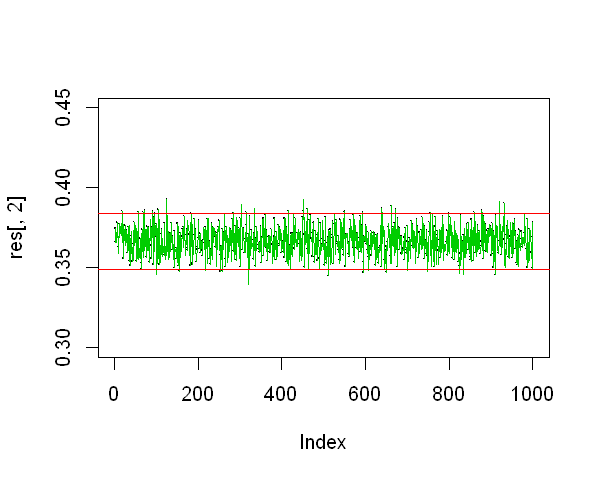

In [64]:
options(repr.plot.width=5, repr.plot.height=4)
DI_confInt_delta <- round(dispImp(datBas[,"sex"], datBas[,"income"]), 3)
plot(res[,2],ylim=c(0.3,0.45),pch='.')
lines(res[,2],col=3,pch='.')
abline(h=DI_confInt_delta[c(1, 3)], col=2) 

**Q** Que dire des estimations du *DI* sur les échantillons bootstrap par rapport aux bornes de l'intervalle de confiance ?

En rouge: intervalle de confiance à 95% de DI, calculé par la delta method (hyp. de normalité asymptotique)

Les points noirs: DI calculé sur un echantillon boostrap (tirage de n echantillon avec remise)

**Les estimations du DI sont encadrées par l'intervalle de confiance. Autrement dit, les estimations sont faites avec un intervalle de confiance dans les bornes**

Ce graphique confirme que le calcul de DI par la delta method est correct.

>**On peut donc utiliser le calcul de la DI par la delta method car il est plus rapide**

Une fonction de la librairie `boot` fournit une estimation bootstrap de l'intervalle de confiance.

In [65]:
library(boot)
fc <- function(d, i){ 
    d2 <- d[i,]
    return(statistic=dispImp(d2$sex,d2$income)[2])
}
set.seed(11)
bootDI <- boot(datBas,fc, R=1000)
bootDI

Warning message:
"package 'boot' was built under R version 3.6.3"


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = datBas, statistic = fc, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.3666135 9.319226e-05 0.009029887

In [66]:
boot.ci(boot.out = bootDI, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootDI, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 0.3494,  0.3848 )  
Calculations and Intervals on Original Scale

**Q** Comparer l'approximation par delta method et l'estimation bootstrap de intervalle de confiance.

**Les estimations du DI sont encadrées par l'intervalle de confiance. Autrement dit, les estimations sont faites avec un intervalle de confiance dans les bornes**

**Ce graphique confirme que le calcul de DI par la delta method est correct.**

**Q** Compte tenu des temps de calcul, que privilégier?

>On peut donc utiliser le calcul de la DI par la delta method car il est plus rapide

### 4.5 Effet disproportionné des prévisions 
Le même ratio ou impact disproportionné calculé sur les prévisions $g(X)$ de $Y$ plutôt que sur $Y$ mesure explicitement l'effet de la prévision. Il revient à tester l'égalité des taux de prévision favorable entre les deux groupes. 

La valeur seuil de la probabilité pour prédire le niveau de revenu est fixée par défaut à $0.5$.

#### Régression logistique

In [67]:
Yhat=as.factor(pred.log>0.5)

In [71]:
round(dispImp(daTest[,"sex"],Yhat),3)

[1] 0.198 0.232 0.266

#### *Random Forest*

In [69]:
round(dispImp(daTest[,"sex"],pred.rf),3)

[1] 0.304 0.347 0.389

**Q** Comparer les trois intervalles de confiance de l'estimation du *DI* dans le cas des données initiales, de la prévision par régression logistique et de celle par forêt aléatoire. Conclusion?

>**La DI estimée par regression Logistique accentue le biais  [0.19; 0.26]; ce qui est significativement plus petit que celui des données.
Cela est du à sa simplicité.** 

>**La DI estimée par random forest est comparable à celle obtenue dans les données initiales. Le biais est reproduit mais pas accentué.**

#### Effet disproportionné des prévisions sans la variable sensible sexe

In [72]:
Yhat_g=as.factor(pred_g.log>0.5)
round(dispImp(daTest[,"sex"],Yhat_g),3)

[1] 0.218 0.253 0.289

**Q** Que devient le DI avec une prévision n'utilisant pas la variable sensible?

>**La DI estimée par regression Logistique accentue le biais [0.22; 0.29]; ce qui est significativement plus petit que celui des données. Cela est du à sa simplicité.
   Cela est du a la redondance de l'information sexe dans les autres variables**.


Le [calepin long](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb) vérifie ces résultats en considérant (validation croisée *Monte Carlo*) 20 réplications de la séparation des échantillons d'apprentissage et de test sur lesquels sont entraînés trois algorithmes: logistique linéaire, arbre de décision, *random forest*, avant d'évaluer le DI observé sur la prévision de l'échantillon test. 

Comme attendu, la précision dépend fortement de l'algorithme choisi mais aussi, c'est important et moins attendu, de l'estimation du *DI*. De façon relativement contre-intuitive, meilleure est la précision et moins le biais est renforcé par rapport à celui `DIbase` des données d'entraînement. Mais, pour un algorithme donné, le *DI* n'est pas corrélé à la précision sur un échantillon d'apprentissage.

**Q** Conclusion partielle sur l'impact de chaque algorithme, dont il faudrait aussi prendre en compte les capacités d'interprétabilité, surtout vis-à-vis de la loi américaine.

**Attention** comme le rappelle Friedler et al. (2019) les résultats et conclusions peuvent changer d'un jeu de données à un autre. C'est déjà bien connu en ce qui concerne la précision de la prévision, il est nécessaire de l'intégrer dans la gestion du biais. Les résultats présentés dans ce tutoriel, sont sur certains points, différents de ceux de Friedler et al. (2019). La principale raison en est sans doute la différence de stratégie adoptée pour le traitement préalable des données. Par principe, Friedler et al. (2019) analysent sans aucune perspective statistique élémentaire les données brutes et donc sans aucun traitement préalable.

### 4.6 Effet disproportionné *vs. Testing*
#### Enquête commanditée par la DARES
Le *testing* est, à l'origine, une méthode usuelle permettant de détecter une discrimination *directe* opérée par un humain. Elle est "adaptée" (Riach et Rich 2002) et déployée par la ([DARES](http://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/etudes-et-syntheses/dares-analyses-dares-indicateurs-dares-resultats/testing)) du Ministère du Travail  (cf. [article Le Monde 2020](https://www.lemonde.fr/societe/article/2020/01/08/une-etude-montre-des-discriminations-a-l-embauche-significatives-en-fonction-de-l-origine_6025227_3224.html)) à la détection par enquête d'une discrimination indirecte envers un groupe. Il consiste à évaluer la variabilité d'une décision lorsque seule la modalité de la variable sensible est modifiée. 

Les calculs ci-dessous permettent de reproduire les résultats globaux de la dernière enquête de la DARES.

In [73]:
origine.i=matrix(0,10000,1);reponse.i=matrix(0,10000,1)
origine.i[4536:8910]=1;origine.i[9376:10000]=1
reponse.i[8911:10000]=1
origine=factor(origine.i,labels=c("Maghreb","France"))
reponse=factor(reponse.i,labels=c("Negative","Positive"))
table(reponse, origine)

          origine
reponse    Maghreb France
  Negative    4535   4375
  Positive     465    625

In [74]:
100*465/5000;100*625/5000; 465/625

[1] 9.3

[1] 12.5

[1] 0.744

Les ratios sont bien ceux de l'enquête. Il y a de très nombreuses façons de les comparer afin de conclure ou non à une discirmination jugée significative. Que donne l'évaluation de l'effet disproportionné?

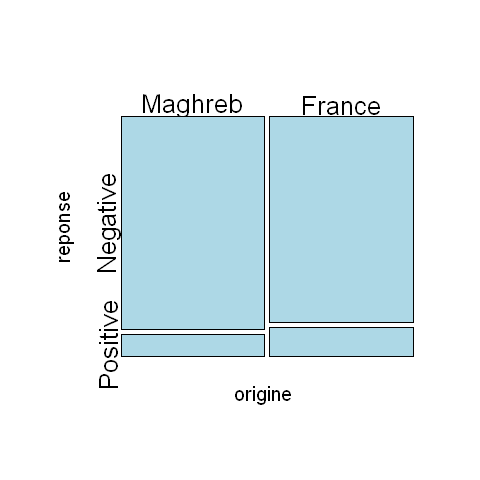

In [75]:
options(repr.plot.width=4, repr.plot.height=4)
mosaicplot(table(origine,reponse),main="",col="lightblue",cex=1.3)

In [76]:
round(dispImp(origine,reponse),3)

[1] 0.660 0.744 0.828

**Q** Cette enquête par *testing* met-elle en évidence une discrimination statistiquement significative au regard du règlement américain (règle des 4/5ème)?

>**Cette enquete ne met pas forcement en evidence une discrimination  statistiquement significative si on considère tout l'intervalle de confiance qui contient 0.8
Par contre si on considere uniquement la valeur.**


**Q** Que dire de la précision de l'évaluation du *DI* avec 10 000 CVs envoyés? Serait-il possible de conclure pour une entreprise donnée?

>**L'évaluation n'est pas précise car l'intervalle de confince est tres grand.
  Pour une entreprise donnée, il est presqu'impossible d'envoyer 10 000 CVs. Par contre, si on envoie un nombre de Cvs plus faible on ne va qu'augmenter l'Intervalle de Confiance.** 

#### *Testing* d'un algorithme d'apprentissage
Que se passe-t-il si le *testing* est appliqué à une décision automatique pilotée par un algorithme d'apprentissage? 

Les prévisions de revenu sont calculées pour les mêmes personnes de l'échantillon test en prenant en compte le sexe initial puis le sexe opposé. Dans ce cas, une femme pour laquelle la prévision de revenu ou solvabilité change lorsque la variable sexe passe de `Female` à `Male` serait en droit d'intenter une action en justice pour discrimination directe. 

In [77]:
daTest2=daTest
# Changement de genre
daTest2$sex=as.factor(ifelse(daTest$sex=="Male","Female","Male"))
# Prévision du "nouvel" échantillon test
pred2.log=predict(log.lm,daTest2,type="response")
Yhat2=as.factor(pred2.log>0.5)

In [78]:
table(Yhat,Yhat2)

       Yhat2
Yhat    FALSE TRUE
  FALSE  7064   25
  TRUE    141 1713

In [79]:
# répartition par genre
table(Yhat,Yhat2,daTest$sex)

, ,  = Female

       Yhat2
Yhat    FALSE TRUE
  FALSE  2662   25
  TRUE      0  183

, ,  = Male

       Yhat2
Yhat    FALSE TRUE
  FALSE  4402    0
  TRUE    141 1530


**Q** Compléter: Il y a $x+y$ personnes dont la prévision de revenu change lorsqu'elles changent de genre. Et le changement est dans le sens attendu.
- $x$ femmes passent d'une prévision de revenu faible à une prévision de revenu élevé
- $y$ hommes prennnent le chemin inverse  lorsqu'ils deviennent des femmes; ces hommes bénificiaient donc d'une discrimination positive!

Quels résultats fourniraient une enquête par testing consistant à envoyer deux fois les "dossiers" à l'algorithme, une fois pour chaque sexe? Il faut donc considérer deux fois plus de personnes en concaténant les deux prévisions. Ceci conduit à la table de contingence ci-dessous. 

>**x= 25 voir Yhat2 (TRUE) et 0 femmes ont eu une baisse de salaire en passant à Homme et y= 141**

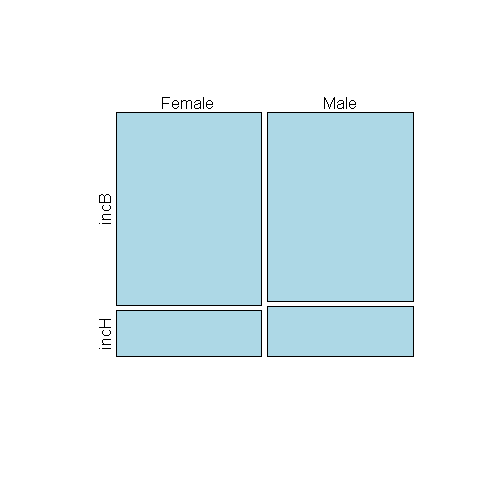

In [81]:
# fonction de concaténation de deux vecteurs de type factor
c.factor <- function(..., recursive=TRUE) unlist(list(...), recursive=recursive) 
Yhat=factor(Yhat,labels=c("incB","incH")); Yhat2=factor(Yhat2,labels=c("incB","incH"))
mosaicplot(table(c.factor(daTest$sex,daTest2[,"sex"]),c.factor(Yhat,Yhat2)),main="",col="lightblue",cex=.8)

In [82]:
round(dispImp(c.factor(daTest$sex,daTest2[,"sex"]),c.factor(Yhat,Yhat2)),3)

[1] 0.858 0.912 0.965

**Q** Conclusion: le testing est-il adapté à détecter une disrimination algorihtmique?

>**Non, le testing n'est pas adapté car on a une DI élevée. le testing ne detecte pas le biais**

**Q** A quoi est principalement due cette incapacité? Penser au rôle de la variable sexe dans les prévisions.

>**Cela est du au fait que l'information de sexe est contenue dans mes autre variables**

#### *Testing* et prévision "déloyale" 
Une façon simple pour une entreprise de se prémunir contre une opération de *testing* consiste à fixer comme probablité prédite le maximum des deux probablités obtenues en échangeant les modalités de la variable sensible. De façon générale, choisir la situation la plus favorable pour la personne quelque soit le sexe observé. La discrimination individuelle repérable par *testing* est neutralisée et l'influence sur le taux d'erreur quasi négligeable. 

In [ ]:
fairPredictGenre=pmax(pred.log, pred2.log) 
confMat=table(fairPredictGenre>0.5,daTest$income)
confMat;tauxErr(confMat)

In [ ]:
round(dispImp(daTest$sex,as.factor(pred.log>0.5)),3)
round(dispImp(daTest$sex,as.factor(fairPredictGenre>0.5)),3)

**Attention** Cette procédure masque de façon **intentionnelle** la discrimination directe détectable tout en favorisant une discrimination indirecte, elle est clairement **condamnable au sens du code pénal**. Soyez prudent dans vos futures pratiques professionnelles!

## 5 Expliquer, atténuer la discrimination ?
De façon notable, le modèle de régression logistique reproduit le biais social et le renforce en introduisant donc de la discrimination; c'est moins net pour l'algorithme des forêts aléatoires,  Est-il possible d'expliquer ce comportement ou plus précisément d'utiliser le bon modèle ou bon algorithme qui l'évite? Le [calepin long](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb) compare différents algorithmes selon diverses situations notamment en attribuant sans succès plus de poids aux femmes afin de compenser leur sous-représentation. 

La littérature propose une avalanche de méthodes pour débiaiser une décision algorithmique. Trois approches sont développées:
- *Pre-processing* en débiaisant les données d'apprentissage;
- *Processing* en pénalisant la fonction objectif avec une contrainte d'équité mais l'optimisation n'est plus convexe;
- *Post-processing* en dé-biaisant les décisions.

Friedler et al. (2019) et le site [AIF360](https://aif360.mybluemix.net/) proposent une comparaison numérique systématique de quelques unes de ces approches sur plusieurs jeux de données publiques donc celui de ce tutoriel. Les codes de Friedler et al. (2019) sont disponibles sur un dépôt et une version "simplifiée" est accessible dans un [autre tutoriel](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-Python-BiasDetectionBiblio.ipynb) en python qui focalise les calculs sur ce seul jeu de données.

Une version rudimentaire mais efficace de post-processing consiste à estimer deux modèles ou entraîner deux algorithmes, l'un pour les femmes et l'autre pour les hommes puis d'adapter le seuil de décision afin de réduire l'effet disproportioné tout en contrôlant le taux d'erreur. Cette procédure est testée dans les deux cas de la régression logistique et des forêts aléatoires. C'est une façon d'introduire une dose de discrimination positive afin d'infléchir vers plus d'équité sociale.

Une première partie consiste à estimer séparément les modèles avant d'introduire de la discrimination positive dans une deuxième partie.

**Remarque** Il n'est sans doute pas nécessaire d'estimer deux modèles de forêts aléatoires selon le genre. Le seul post-processing des seuils de décision devrait suffire. C'est le choix pris, surtout pour la régression logistique, afin de prendre en compte l'effet important des interactions dans le modèle. 


### 5.1 Séparation des deux échantillons
Les échantillons sont séparés en deux parties.

In [83]:
datAppF=subset(datApp, sex == 'Female') 
datAppM=subset(datApp, sex == 'Male')
daTestF=subset(daTest, sex == 'Female')
daTestM=subset(daTest, sex == 'Male')
summary(datAppM)

      age           educNum               mariStat              occup      
 Min.   :18.00   Min.   : 1.00   Married      :15086   Admin       : 1462  
 1st Qu.:30.00   1st Qu.: 9.00   Never-Married: 6295   Blue-Collar :10556  
 Median :38.00   Median :10.00   Not-Married  : 2641   Other-occups: 1364  
 Mean   :39.44   Mean   :10.14   Widowed      :  170   Professional: 3030  
 3rd Qu.:48.00   3rd Qu.:13.00                         Sales       : 2770  
 Max.   :90.00   Max.   :16.00                         Service     : 1624  
                                                       White-Collar: 3386  
    origEthn         sex          hoursWeek      income       LcapitalGain    
 CaucNo : 2801   Female:    0   Min.   : 1.00   incB:16533   Min.   : 0.0000  
 CaucYes:21391   Male  :24192   1st Qu.:40.00   incH: 7659   1st Qu.: 0.0000  
                                Median :40.00                Median : 0.0000  
                                Mean   :43.03                Mean   : 0.8767

### 5.2 Régression logistique
Estimation des deux modèles.

In [84]:
reg.log=glm(income~.,data=datApp,family=binomial)
# estimation des deux modèles
reg.logF=glm(income~.,data=datAppF[,-6],family=binomial)
reg.logM=glm(income~.,data=datAppM[,-6],family=binomial)
# comparaison des paramètres
summary(reg.logF);summary(reg.logM)


Call:
glm(formula = income ~ ., family = binomial, data = datAppF[, 
    -6])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7690  -0.3124  -0.1678  -0.0831   3.2625  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -6.742623   0.326805 -20.632  < 2e-16 ***
age                    0.028402   0.003600   7.891 3.01e-15 ***
educNum                0.343346   0.021937  15.652  < 2e-16 ***
mariStatNever-Married -3.268889   0.110020 -29.712  < 2e-16 ***
mariStatNot-Married   -3.188778   0.103446 -30.826  < 2e-16 ***
mariStatWidowed       -3.081489   0.184452 -16.706  < 2e-16 ***
occupBlue-Collar      -0.245903   0.171400  -1.435 0.151382    
occupOther-occups      0.612643   0.179734   3.409 0.000653 ***
occupProfessional      0.628217   0.123516   5.086 3.65e-07 ***
occupSales             0.163156   0.150072   1.087 0.276958    
occupService          -0.508863   0.163657  -3.109 0.001875 ** 
occupWhite-Collar      0


Call:
glm(formula = income ~ ., family = binomial, data = datAppM[, 
    -6])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7648  -0.6781  -0.2509   0.6394   3.6045  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -5.564451   0.167767 -33.168  < 2e-16 ***
age                    0.024393   0.001594  15.302  < 2e-16 ***
educNum                0.267017   0.008953  29.824  < 2e-16 ***
mariStatNever-Married -2.182519   0.068031 -32.081  < 2e-16 ***
mariStatNot-Married   -1.655723   0.067102 -24.675  < 2e-16 ***
mariStatWidowed       -1.382355   0.225438  -6.132 8.69e-10 ***
occupBlue-Collar      -0.353455   0.078490  -4.503 6.69e-06 ***
occupOther-occups      0.371642   0.097840   3.798 0.000146 ***
occupProfessional      0.455029   0.087801   5.182 2.19e-07 ***
occupSales             0.169009   0.086645   1.951 0.051107 .  
occupService          -1.174029   0.135264  -8.680  < 2e-16 ***
occupWhite-Collar      0

**Q** La comparaison des paramètres des deux modèles apporte-t-elle des informations?

>**Il n'y a pas une grande similitude entre les deux osrties. il estd onc difficile de donner une conclusion pertinente**

In [88]:
# prévision des modèles
yHat=predict(reg.log,newdata=daTest,type="response")
yHatF=predict(reg.logF,newdata=daTestF,type="response")
yHatM=predict(reg.logM,newdata=daTestM,type="response")
# compilation des prévisions
yHatFM=c(yHatF,yHatM)

In [89]:
daTestFM=rbind(daTestF,daTestM)
dim(daTestFM)

[1] 8943   11

In [90]:
# erreurs cumulées
table(yHatFM>0.5,daTestFM$income)

       
        incB incH
  FALSE 6169  879
  TRUE   577 1318

In [91]:
table(yHat>0.5,daTest$income)

       
        incB incH
  FALSE 6190  899
  TRUE   556 1298

In [92]:
tauxErr(table(yHatFM>0.5,daTestFM$income))

[1] 16.28

In [93]:
tauxErr(table(yHat>0.5,daTest$income))

[1] 16.27

**Q** Que devient l'erreur de prévision une fois que les deux modèles sont associés avec le même seuil de décision?

In [ ]:
# biais cumulés vs. biais 
round(dispImp(daTestFM[,"sex"],as.factor(yHatFM>0.5)),3); round(dispImp(daTest[,"sex"],as.factor(yHat>0.5)),3)

In [ ]:
# Rappel: Biais de la base de test
round(dispImp(daTestFM[,"sex"],daTestFM[,"income"]),3)

**Q** Que devient le bais?

### 5.3 *Random Forest*

In [ ]:
library(randomForest)
# Modèle initial
RFinit=randomForest(income~.,data=datApp)
# Modèle en changeant les poids
RFinitW=randomForest(income~.,data=datApp,weigth=w)
# estimation des deux modèles
RF.F=randomForest(income~.,data=datAppF[,-6])
RF.M=randomForest(income~.,data=datAppM[,-6])
# comparaison des paramètres

In [ ]:
# prévision des modèles
yHatrf=predict(RFinit,newdata=daTest,type="response")
yHatrfW=predict(RFinitW,newdata=daTest,type="response")
yHatFrf=predict(RF.F,newdata=daTestF,type="response")
yHatMrf=predict(RF.M,newdata=daTestM,type="response")
# compilation des prévisions
yHatFMrf=c(yHatFrf,yHatMrf)

In [ ]:
# erreurs cumulées vs. erreur initiale de RF
table(yHatFMrf,daTestFM$income); table(yHatrf,daTest$income)

**Q** Comparer les erreurs.

In [ ]:
tauxErr(table(yHatFMrf,daTestFM$income)); tauxErr(table(yHatrf,daTest$income))
tauxErr(table(yHatrfW,daTest$income))

In [ ]:
# Biais cumulé vs. biais du modèle initial vs. biais de la base
round(dispImp(daTestFM[,"sex"],as.factor(yHatFMrf)),3);round(dispImp(daTest[,"sex"],as.factor(yHatrf)),3);
round(dispImp(daTest[,"sex"],as.factor(yHatrfW)),3);round(dispImp(daTestFM[,"sex"],daTestFM[,"income"]),3)

**Q** Comparer les biais.
### 5.4 Atténuation de la discrimination par *post-processing*
La procédure (*post-processing*) ci-dessous est la plus simple. Elle consiste à introduire une forme de discrimination positive en intervenant sur le seuil de décision pour les femmes tout en conservant celui de $0.5$ pour les hommes. Elle est appliquée dans ce tutoriel au seul algorithme de forêt aléatoire. Une procédure graphique d'optimisation a été appliquée mais non reproduite afin de contrôler, sur l'échantillon test initial, l'effet de la correction à la fois sur le biais et sur l'erreur de prévision. Le seuil choisi ($0.7$) pour les femmes pour décider d'un revenu faible ($<50$k$) en découle. *Attention* ce seuil peut dépendre de l'échantillon test et donc de l'initialisation du générateur de nombres aléatoires. Une procédure de validation croisée serait bienvenue!

Par ailleurs, il n'est sans doute pas nécessaire de considérer deux modèles un pour les femmes, un pour les hommes, l'intervention d'un seuil conditionnel au sexe devrait suffire. La construction de deux modèles selon le genre a surtout été introduite pour montrer l'importance des effets de possibles interactions en régression logistique.

In [87]:
# prévision des modèles en modifiant le seuil des femmes
yHatFrfDP=predict(RF.F,newdata=daTestF,type="prob")[,1]<0.7
yHatMrfDP=predict(RF.M,newdata=daTestM,type="prob")[,1]<0.5
# compilation des prévisions
yHatFMrfDP=c(yHatFrfDP,yHatMrfDP)

ERROR: Error in predict(RF.F, newdata = daTestF, type = "prob"): objet 'RF.F' introuvable


In [ ]:
table(yHatFMrfDP,daTestFM$income)

In [ ]:
tauxErr(table(yHatFMrfDP,daTestFM$income))

**Q** Que devient l'erreur de prévision?

In [ ]:
round(dispImp(daTestFM[,"sex"],as.factor(yHatFMrfDP)),3)

**Q** Que devient le biais?
### 5.5 Synthèse graphique des résultats
Les résultats précédents: précisions des prévisions et intervalles de confiance sont collectés et affichés sur le même graphique.

**Attention** il serait nécessaire de reprogrammer les commandes précédentes en stockant les résultats au fur et à mesure dans un fichier. Cette opération est laissée à titre d'exercice ;-) Ici le fichier a été reconstruit à la main! Penser à vérifier les résultats, voire à y introduire les votres qui dépendent de l'échantillon test initialement tiré. 

In [ ]:
diAlgos=read.table("diVSalgos-red.txt",header=T)
diAlgos

**Attention**: décommenter la commande d'installation ci-dessous lors d'une exécution dans le nuage ou si tout simplement cette librairie n'est pas installée.

In [ ]:
# install.packages("Publish")
library(Publish)
options(repr.plot.width=10, repr.plot.height=5)
plotConfidence(x=diAlgos[,c("DI","Lower","Upper")],labels=diAlgos[,c("Model","Accuracy")],
               points.pch=15,points.cex=3,points.col=rainbow(6),
              values=FALSE,xlim=c(0.1,1),lwd=4,cex=1.5,
               xlab="Disparate Impact",xlab.cex=1,xratio=0.3,y.title.offset=1)

**Q** Comparer les différents bais en tenant compte de l'intersection des intervalles de confiance? Quels sont les algorithmes qui discriminent significativement? Est-il efficace de retirer la variable sensible du modèle? Le post-processing sur les décisions des forêts aléatoires est-il efficace? Que dire du *testing*?

## 6 Autres indicateurs de biais / discrimination
### 6.1 Biais sur les erreurs ou précisions de prévision conditionnelles
L'effet disproportionné est une première source de biais ou de discrimination parmi d'autres. Une deuxième, souvent évoquée, concerne les erreurs de prévision ou les précisions selon les modalités de la variable sensible; c'est  l'*overall error equality* ou de façon équivalente l'*overall accuracy equality*.

#### Régression logistique linéaire
*Overall error equality*

In [ ]:
table(pred.log>0.5,daTest$income,daTest$sex)

In [ ]:
apply(table(pred.log>0.5,daTest$income,daTest$sex),3,tauxErr)


**Q** Quel genre semble défavorisé au regard de ce critère?

In [ ]:
source('../Functions/overErrEqual.R')

In [ ]:
round(overErrEqual(daTest$sex,daTest$income,as.factor(pred.log>0.5)),2)

**Q** Même question.

#### Random forest

In [ ]:
apply(table(yHatrf,daTest$income,daTest$sex),3,tauxErr)

In [ ]:
round(overErrEqual(daTest$sex,daTest$income,yHatrf),2)

**Q** Quel genre semble défavorisé au regard de ce critère?

#### *Random forest* avec discrimination positive

In [ ]:
tauxErr(table(yHatFrfDP,daTestF$income)); tauxErr(table(yHatMrfDP,daTestM$income))

In [ ]:
round(overErrEqual(daTestFM[,"sex"],daTestFM$income,as.factor(yHatFMrfDP)),2)

**Q** L'évolution de ce critère est elle logique compte tenu de la correction adoptée sur la décision?

### 6.2 Asymétrie de la matrice de confusion: *equalitzed odds* 
Une autre source de discrimination est considére. Elle a été mise en exergue par le site [Propublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) à propos du score de récidive COMPAS de la société *equivant* utilisé dans certaines cours de justice américaines sous une forme de "justice prédictive". Le biais concerne une inversion de l'asymétrie de la matrice de confusion selon la variable sensible. De très nombreux critères ont été proposés pour évaluer cette asymétrie et dont [Verma et Rubin (2018](http://fairware.cs.umass.edu/papers/Verma.pdf)) proposent une revue. Leurs définitions sont basées sur les différentes fréquences issues de la table de contingence et calculées par la fonction ci-dessous.

In [ ]:
contRatio <- function(T){ 
    # Ratios calculés à partir de la matrice de confusion
    TP=T[2,2] # true positive
    FP=T[2,1] # false positive
    FN=T[1,2] # false negative
    TN=T[1,1]  # true negative
    PPV=TP/(TP+FP) # P(Y=1|g(x)=1) positive predictive value
    FDR=FP/(TP+FP) # P(Y=0|g(x)=1) false discovery rate 
    FOR=FN/(TN+FN) # P(Y=1|g(x)=0) false omission rate
    NPV=TN/(TN+FN) # P(Y=0|g(x)=0) negative predictive value
    TPR=TP/(TP+FN) # P(g(x)=1|Y=1) true positive rate
    FPR=FP/(FP+TN) # P(g(x)=1|Y=0) false positive rate
    FNR=FN/(TP+FN) # P(g(x)=0|Y=1) false negative rate
    TNR=TN/(FP+TN) # P(g(x)=0|Y=0) true negative rate
    return(list("PPV"=PPV,"FDR"=FDR,"FOR"=FOR,"NPV"=NPV,"TPR"=TPR,"FPR"=FPR,"FNR"=FNR,"TNR"=TNR))
}

In [ ]:
contRatio(table(pred.log>0.5,daTest$income))

Liste de critères d'équité pouvant être définis à partir des fréquences précédentes conditionnellement à la variable sensible. La combinatoire des possibles est importante mais peut être réduite en remarquant que *PPV*=1-*FDR*, *FOR*=1-*NPV*, *FPR*=1-*TNR*, *FNR*=1-*TPR*... Selon les auteurs, il y a équité de traitement si:
- *Predictive parity*: les deux groupes ont les mêmes *PPV*s et par conséquence les mêmes *FDR*s;
- *False positive error rate balance* ou *predictive equality*: mêmes *FPR*s et par conséquence les mêmes *TNR*s;
- *False negative error rate balance* ou *equal opportunity*: mêmes *FNR*s et par conséquence les mêmes *TPR*s;
- *Conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds* combine les deux ci-dessus: mêmes *TPR*s **ET** mêmes *FPR*s;
- *Overall accuracy equality*: mêmes *TPR* **ET** mêmes *TNR*;
- *Conditionnal use accuracy equality*: mêmes *PPV*s **ET** mêmes *NPV*s;
- *Teatment equality*: les rapports *FN/FP* sont les mêmes pour les deux groupes.

Bien d'autres critères ont été proposés (cf. Verma et Rubin. 2018), il ne sont pas développés ici. Les calculs des *TPR* et *TNR* conditionnels sont privilégiés ci-dessous mais ce n'est qu'un choix parmi d'autres. Friedler et al. (2019) montrent que ceux-ci sont très corrélés. Il serait raisonnable de se limiter aux seules comparaisons des *TPR* et *FPR*.

#### Régression logistique linéaire
La matrice de confusion est construite pour chaque genre pour comparer les différents indicateurs de loyauté.

In [ ]:
fairness=data.frame("Female"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$sex)[,,1])),
                    "Male"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$sex)[,,2])))
fairness

Il serait fastidieux de construire toutes les comparaisons d'autant que beaucoup de ces indicateurs sont redondants. Seuls les  ***Equalized Odds*** sont estimés par des intervalles de  confiance à l'aide de la fonciton `oddsEqual` qui  admet 4 paramètres:
- S: variable du groupe protégé
- Y: variable cible
- P: prévision $\hat{Y}$
- alpha=0.05, valeur par défaut.

Elle fournit l'estimation par intervalle de confiance des rapports des *FPR* et *TPR* conditionnels et permet donc de tester l'égalité ou non des cotes selon la variable sensible.

In [ ]:
source('../Functions/oddsEqual.R')

In [ ]:
round(oddsEqual(daTest$sex,daTest$income,as.factor(pred.log>0.5)),2)

**Q** Quel genre semble cette fois favorisé au sens de ce critère?

#### *Random forest* 

In [ ]:
fairnessRF=data.frame("Female"=as.matrix(contRatio(table(yHatrf,daTest$income,daTest$sex)[,,1])),
                    "Male"=as.matrix(contRatio(table(yHatrf,daTest$income,daTest$sex)[,,2])))
fairnessRF

In [ ]:
round(oddsEqual(daTest$sex,daTest$income,yHatrf),2)

**Q** Même question avec une forêt aléatoire.

#### *Random forest* avec discrimination positive

In [ ]:
fairnessRFDP=data.frame("Female"=as.matrix(contRatio(table(yHatFrfDP,daTestF$income))),
                    "Male"=as.matrix(contRatio(table(yHatMrfDP,daTestM$income))))
fairnessRFDP

In [ ]:
round(oddsEqual(daTestFM[,"sex"],daTestFM$income,as.factor(yHatFMrfDP)),2)

**Q** La correction va-t-elle dans le sens attendu? 

**Q** En conclusion, le traitement par post-processing du seuil va-t-il, pour cet exemple, dans le bon sens pour tous les critères de biais?

## Conclusion

Conclure sur 
- le choix entre un modèle linéaire ou non linéaire, 
- l'intervention de la variable sensible dans un modèle et donc sur l'effet d'une interdiction de prendre en compte une variable sensible comme l'origine ethnique,
- l'efficacité du testing, 
- celle du post processing rudimentaire mis en oeuvre.

**Remarques** .
- Il n'est sans doute pas nécessaire d'estimer deux modèles de forêts aléatoires selon le genre. Le seul post-processing des seuils de décision devrait suffire.
- Les entreprises proposant du recrutement prédictif en France ne se préoccupent pas de ces "détails",
- contrairement à ce qui se passe aux USA où le calcul de l'*adverse* ou *disparate impact* est pris en compte par obligation du code du travail en tenant à jour des "statistiques ethniques".
- Aux USA, l'utilisation d'un algorithme non linéaire sans contrôle est risquée car un biais trop important ($DI<0.8$) sans explication, donc justification possible, est condamnable. C'est la raison pour laquelle certaines entreprises américaines de la *hiring tech* proposent des atténuations du biais afin d'économiser des poursuites judiciaires (Raghavan et al. 2019).
- Un `data scientist` dispose actuellement d'une grande latitude pour faire ce qu'il veut, sans contrôle, du comportement déloyal, condamnable, à la discrimination positive pour introduire plus d'équité dans la société!
- Nous pouvons espérer, qu'après la mise en place du RGPD, la Commission Européenne intervienne rapidement sur ces questions. C'est en tous cas le sens des directives annoncées dans le [livre blanc](https://ec.europa.eu/info/sites/info/files/commission-white-paper-artificial-intelligence-feb2020_fr.pdf).
- Un gros travail en vue pour un *data scientist* responsable d'un traitement qui devra tenir à jour une documentation complète et détaillée (liste d'évaluation) de toutes ces procédures, du recueil des données au suivi d'un système d'intelligence artificielle en exploitation.

## Références
Barocas S., Selbst A. (2016). [Big Data's Disparate Impact](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2477899), *California Law Review*, 671.

Besse P. (2020). [Détecter, évaluer les risques des impacts discriminatoires des algorithmes d'IA](https://hal.archives-ouvertes.fr/hal-02616963), Contribution au séminaire Défenseur des Droits et CNIL, 28 mai 2020, article soumis.

Besse P., del Barrio E., Gordaliza P., Loubes J.-M. (2018). [Confidence Intervals for testing Disparate Impact in Fair Learning](https://arxiv.org/abs/1807.06362), arXiv preprint.

Efron B. (1987). [Better Bootstrap Confidence Intervals](https://www.jstor.org/stable/2289144?seq=1), *Journal of the American Statistical Association*, Vol. 82, No. 397 (Mar., 1987), pp. 171-185. 

Friedler S., Scheidegger C., Venkatasubramanian S., Choudhary S., Hamilton E., Roth D. (2019). [A comparative study of fairness-enhancing interventions in machine learning](https://dl.acm.org/doi/10.1145/3287560.3287589), *Proceedings of the Conference on Fairness, Accountability, and Transparency*.

Morris S., Lobsenz R. (2000), [Signifiance Tests and Confidence Intervals for the Adverse Impact Ratio](https://doi.org/10.1111/j.1744-6570.2000.tb00195.x) *Personnel Psychology*, 53: 89-111.

Riach, P., Rich J. (2002). [Field Experiments of Discrimination In The Market Place]( https://doi.org/10.1111/1468-0297.00080), *The Economic Journal*, Vol. 112, 480-518.

Raghavan M., Barocas S., Kleinberg J., Levy K. (2019) [Mitigating bias in Algorithmic Hiring : Evaluating Claims and Practices](https://arxiv.org/abs/1906.09208), arXiv:1906.09208.

Verma S., Rubin J. (2018). [Fairness Definitions Explained](http://fairware.cs.umass.edu/papers/Verma.pdf),  *ACM/IEEE International Workshop on Software Fairness*.

Zliobaitė I. (2015). [A survey on measuring indirect discrimination in machine learning](https://arxiv.org/pdf/1511.00148.pdf), arXiv preprint.
